### 언어 판별 프로그램

In [1]:
from sklearn import svm, metrics
import glob, os.path, re, json

In [3]:
def check_freq(fname):
    name = os.path.basename(fname)
    lang = re.match(r'^[a-z]{2,}',name).group() # regex 에서 ^ 가 없어도 출력 결과는 같다.  e.g. en-3.txt -> en
    with open(fname, 'r', encoding='utf-8') as f:
        text = f.read()
    
    text  = text.lower()
    
    #숫자 세기  변수(cnt) 초기호하기
    cnt = [0  for n in range(0,26)]
    code_a = ord('a')
    code_z = ord('z')
    
    #알파벳 출현 횟수 구하기
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z:
            cnt[n - code_a] += 1
    # 정규화 하기
    total = sum(cnt)
    freq = list(map(lambda n: n/total,cnt))
    return (freq, lang)

def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}

data = load_files('../data/lang/train/*.txt')
test = load_files('../data/lang/test/*.txt')

# 이후를 대비해서 JSON으로 결과 저장하기
with open('../data/lang/freq.json', 'w', encoding='utf-8') as fp:
    json.dump([data, test], fp)
    
clf = svm.SVC()
clf.fit(data['freqs'], data['labels'])

predict = clf.predict(test['freqs'])

ac_score = metrics.accuracy_score(test['labels'], predict)
cl_report= metrics.classification_report(test['labels'], predict)

print('정답률:', ac_score)
print("리포트=")
print(cl_report)
    

정답률: 0.875
리포트=
             precision    recall  f1-score   support

         en       0.67      1.00      0.80         2
         fr       1.00      1.00      1.00         2
         id       1.00      0.50      0.67         2
         tl       1.00      1.00      1.00         2

avg / total       0.92      0.88      0.87         8



array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B8E3518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BAAB470>], dtype=object)

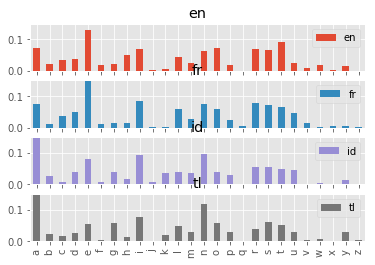

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

with open('../data/lang/freq.json', 'r', encoding='utf-8') as fp:
    freq = json.load(fp)
    
lang_dic = {}
for i, lbl in enumerate(freq[0]['labels']):
    fq = freq[0]['freqs'][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2
        
asclist = [[chr(n) for n in range(97, 97+26)]]
df = pd.DataFrame(lang_dic, index=asclist)

plt.style.use('ggplot')
df.plot(kind='bar', subplots=True, ylim=(0,0.15))

In [ ]:
#!/usr/bin/env python3
import cgi, os.path
from sklearn.externals import joblib
# 학습 데이터 읽어 들이기
pklfile = os.path.dirname(__file__) + "/freq.pkl"
clf = joblib.load(pklfile)
# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=utf-8")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg))
# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower() 
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n < 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "입력이 없습니다"
    freq = list(map(lambda n: n/total, cnt))
    # 언어 예측하기
    res = clf.predict([freq])
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en":"영어","fr":"프랑스어",
        "id":"인도네시아어", "tl":"타갈로그어"}
    return lang_dic[res[0]]
# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage()
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과:" + lang
# 입력 양식 출력
show_form(text, msg)